# Automated ML

TODO: Import Dependencies. In the cell below, import all the dependencies that you will need to complete the project.

In [ ]:
from azureml.core import Workspace, Experiment

from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

from azureml.data.dataset_factory import TabularDatasetFactory
from azureml.core import Dataset

#import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from azureml.train.automl import AutoMLConfig

from azureml.core import Model
from azureml.core.webservice import AciWebservice, Webservice

## Dataset

### Overview
TODO: In this markdown cell, give an overview of the dataset you are using. Also mention the task you will be performing.


TODO: Get data. In the cell below, write code to access the data you will be using in this project. Remember that the dataset needs to be external.

In [5]:
ws = Workspace.from_config()
exp = Experiment(workspace=ws, name="capstone")

print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

run = exp.start_logging()

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code F7H77PKZC to authenticate.
You have logged in. Now let us find all the subscriptions to which you have access...
Interactive authentication successfully completed.
Workspace name: quick-starts-ws-137812
Azure region: southcentralus
Subscription id: b968fb36-f06a-4c76-a15f-afab68ae7667
Resource group: aml-quickstarts-137812


In [6]:
cpu_cluster_name = "udacity-project3"

# Verify that cluster does not exist already
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',
                                                           max_nodes=4)
    cpu_cluster = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

cpu_cluster.wait_for_completion(show_output=True)

Creating
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [84]:
train_link = 'https://raw.githubusercontent.com/piprzyb/Azure3/main/train.csv'
test_link = 'https://raw.githubusercontent.com/piprzyb/Azure3/main/test.csv'
data_train = Dataset.Tabular.from_delimited_files(path=train_link)
data_test = Dataset.Tabular.from_delimited_files(path=test_link)

dataset=data_train.to_pandas_dataframe()
test = data_test.to_pandas_dataframe()

dataset = dataset.append(test)

print(dataset.size)
dataset.head()

750


,sepal_length,sepal_width,petal_length,petal_width,iris_class
0,4.6,3.6,1.0,0.2,Iris-setosa
1,5.7,4.4,1.5,0.4,Iris-setosa
2,6.7,3.1,4.4,1.4,Iris-versicolor
3,4.8,3.4,1.6,0.2,Iris-setosa
4,4.4,3.2,1.3,0.2,Iris-setosa


In [85]:
dataset.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


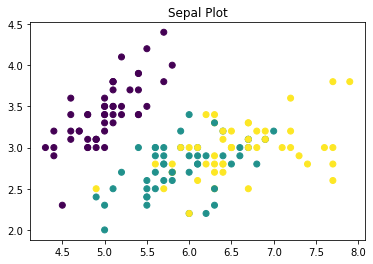

In [86]:
plt.title("Sepal Plot")
plt.scatter('sepal_length', 'sepal_width', c=dataset.iris_class.map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}), data=dataset)
plt.show()

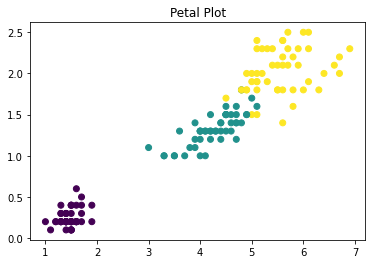

In [87]:
plt.title("Petal Plot")
plt.scatter('petal_length', 'petal_width', c=dataset.iris_class.map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}), data=dataset)
plt.show()

In [88]:
dataset.size

750

In [89]:
print('Train size', train.size)
print('Test size', test.size)

Train size 600
Test size 150


## AutoML Configuration

TODO: Explain why you chose the automl settings and cofiguration you used below.

In [90]:
# TODO: Put your automl settings here
automl_settings = {
    'experiment_timeout_minutes': 15,
    'primary_metric' : 'accuracy',
    'n_cross_validations': 5
}

# TODO: Put your automl config here
automl_config = AutoMLConfig(compute_target=cpu_cluster,
                             task = "classification",
                             training_data=data_train,
                             label_column_name='iris_class', 
                             enable_early_stopping= True,
                             experiment_timeout_minutes= 15,
                             primary_metric = 'accuracy',
                             n_cross_validations= 5
                            )

In [ ]:
# TODO: Submit your experiment
#remote_run = exp.submit(automl_config)
remote_run.wait_for_completion(show_output=True)

## Run Details

OPTIONAL: Write about the different models trained and their performance. Why do you think some models did better than others?

TODO: In the cell below, use the `RunDetails` widget to show the different experiments.

In [ ]:
RunDetails(remote_run).show()

## Best Model

TODO: In the cell below, get the best model from the automl experiments and display all the properties of the model.



In [ ]:
best_run, best_model = remote_run.get_output()
best_run_metrics = best_run.get_metrics()

best_run

In [ ]:
best_model

In [ ]:
print('Best Run Id: ', best_run.id)
print('Accuracy:', best_run_metrics['accuracy'])
print(best_model._final_estimator)

In [ ]:
#TODO: Save the best model
os.makedirs('./outputs', exist_ok=True)

joblib.dump(fitted_model, filename='outputs/automl.joblib')

model_name = best_run.properties['model_name']
print(model_name)

## Model Deployment

Remember you have to deploy only one of the two models you trained.. Perform the steps in the rest of this notebook only if you wish to deploy this model.

TODO: In the cell below, register the model, create an inference config and deploy the model as a web service.

In [ ]:
model = best_run.register_model(model_name = 'automl_model', 
                                                model_path='outputs/automl.joblib')

aci_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=2,
                                                enable_app_insights=True, auth_enabled=True)  

service_name = 'service_aml'
service = Model.deploy(ws, service_name, [model], deployment_config=aci_config)
service.wait_for_deployment(show_output = True)
print(service.state)
print(service.scoring_uri)


TODO: In the cell below, send a request to the web service you deployed to test it.

In [ ]:
test_ws = train.tail()
target = test_ws['iris_class']
test_ws = test_ws[:-1]

test_json = json.dumps({'data':test_ws.to_dict(orient='records')})
print(test_json)

results = service.run(teste_json)
print('Model results:', results)
print('Actual results:', y_actual.values)

TODO: In the cell below, print the logs of the web service and delete the service

In [ ]:
print(service.get_logs())

service.delete()